<a href="https://colab.research.google.com/github/IUT-Thesis-Group-Cmr/ML-Project/blob/master/ML_Project_Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization tweaks**
* Initiating GoogleDrive mounting
* Necessary Library's imports
* Load Dataset [**Optional**]


In [185]:
#-Google Drive Access-Granting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
# files paths
path = '/content/drive/My Drive/ThesisFile/datasets/ml-project/fake_real-news-dataset/'
if path[-1] != '/':
  path += '/'
print('Good to go ✔')

Good to go ✔


In [187]:
#-Library imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math 
import nltk
import string
from time import time
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.utils import validation
from sklearn.utils.extmath import density
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, pairwise_distances, mean_absolute_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from seaborn import heatmap
from math import exp
from random import randint, seed
import itertools
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
from collections import deque

%matplotlib inline

In [188]:
def nclass_classification_mosaic_plot(n_classes, results):
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prdiction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]
    ]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)]*2
    mosaic_tuples = tuple(itertools.product(*class_lists))
    
    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t:res_list[i] for i,t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(11, 10))
    plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
    pallet = [
        '#6a89cc', 
        '#4a69bd', 
        '#1e3799', 
        '#0c2461',
        '#82ccdd',
        '#60a3bc',
    ]
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)):{'color':all_colors[i]} for i,(a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ''

    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {
        'fontsize': 20,
        'color' : font_color,
    }
    axis_label_font_dict = {
        'fontsize': 16,
        'color' : font_color,
    }

    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.axes.yaxis.set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=14)

    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [Patch(facecolor=all_colors[i], label='Class {}'.format(i)) for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.018), fontsize=16)

    plt.tight_layout()
    plt.show()

In [189]:
# Loading Dataset
file0 = 'news.csv'
file1 = 'Fake.csv'
file2 = 'True.csv'

df0 = pd.read_csv(path + file0)
df1 = pd.read_csv(path + file1)
df2 = pd.read_csv(path + file2)

print(df0.columns, df0, sep='\n', end='\n\n')
print(df1.columns, df1, sep='\n', end='\n\n')
print(df2.columns, df2, sep='\n', end='\n\n')

df1['label'] = 'FAKE'
df2['label'] = 'REAL'

dataset = pd.concat([df0[['title','text','label']] , df1[['title','text','label']] , df2[['title','text','label']]], ignore_index=True)

dataset = dataset.sample(frac=1).reset_index(drop=True)
print(dataset.columns, dataset.shape)
dataset.tail()

# print('Dataset Attributes::', dataset.columns)
# print('Dataset Dim::', dataset.shape)
# print(dataset.head())
# print('\nData Output::\n', dataset.label)

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
      Unnamed: 0  ... label
0           8476  ...  FAKE
1          10294  ...  FAKE
2           3608  ...  REAL
3          10142  ...  FAKE
4            875  ...  REAL
...          ...  ...   ...
6330        4490  ...  REAL
6331        8062  ...  FAKE
6332        8622  ...  FAKE
6333        4021  ...  REAL
6334        4330  ...  REAL

[6335 rows x 4 columns]

Index(['title', 'text', 'subject', 'date'], dtype='object')
                                                   title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                         

,title,text,label
51228,"Delay seen, again, on Trump growth agenda afte...",NEW YORK (Reuters) - Not even a week after the...,REAL
51229,Russia may send more Iskander missiles to Kali...,MOSCOW (Reuters) - Russia may send more Iskand...,REAL
51230,MISSISSIPPI Gov Signs “Confederate Heritage Mo...,How long will it take for Obama s Army to desc...,FAKE
51231,CIA chief says U.S.-Canadian couple held for f...,WASHINGTON (Reuters) - The head of the CIA sai...,REAL
51232,A Restaurant Worker Has Moved Millions With T...,Footage of a Georgia restaurant worker taking ...,FAKE


# **Analyzing Dataset**


*   Determining the Labels(outputs) and Inputs



In [190]:
# Outputs or Labels
labels = dataset.label;
print(labels)

# Sample Data
df = dataset['text']
df

0        REAL
1        FAKE
2        REAL
3        FAKE
4        FAKE
         ... 
51228    REAL
51229    REAL
51230    FAKE
51231    REAL
51232    FAKE
Name: label, Length: 51233, dtype: object


0        MOSCOW (Reuters) - A foreign policy adviser to...
1        What is the price of one s dignity? Florida Se...
2        UNITED NATIONS (Reuters) - French President Em...
3        The new cold war between Saudi Arabia and Iran...
4        Months into his presidency, Donald Trump seems...
                               ...                        
51228    NEW YORK (Reuters) - Not even a week after the...
51229    MOSCOW (Reuters) - Russia may send more Iskand...
51230    How long will it take for Obama s Army to desc...
51231    WASHINGTON (Reuters) - The head of the CIA sai...
51232    Footage of a Georgia restaurant worker taking ...
Name: text, Length: 51233, dtype: object

# **Splitting the dataset**

*   Split the dataset into training and testing sets.

In [191]:
# Split Dataset with a 8:2 ratio for training and testing
#         sampple data:: the 'text' column only.
x_train,x_test,y_train,y_test = train_test_split(df, labels, test_size=0.2, 
                                                 random_state=7)
print(x_train)
print(y_train)

print(x_test)

6890     Tuesday night was an amazing night for Hillary...
45936    VIENTIANE (Reuters) - U.S. President Barack Ob...
22230    The New York Daily News, once again, has knock...
40082    WARSAW (Reuters) - Poland s political establis...
42905    DES MOINES (Reuters) - An influential conserva...
                               ...                        
13927     It s easy to blame the  White man that way, y...
919      Hillary emails 'whitelisted' for Obama's Black...
38467    Meryl Streep has certainly proven herself capa...
10742    How can we expect our kids to do their homewor...
49689    TALLINN (Reuters) - A physical border between ...
Name: text, Length: 40986, dtype: object
6890     REAL
45936    REAL
22230    FAKE
40082    REAL
42905    REAL
         ... 
13927    FAKE
919      FAKE
38467    FAKE
10742    FAKE
49689    REAL
Name: label, Length: 40986, dtype: object
23499    DNC chairman Tom Perez decided to create his o...
5965     The 2017 Christmas decorations were unveiled i

# **Dataset Preprocessing using a TfidfVectorizer**

Let’s initialize a ***TfidfVectorizer*** with stop words from the English language and a maximum document frequency of 0.7 (terms with a higher document frequency will be discarded). Stop words are the most common words in a language that are to be filtered out before processing the natural language data. And a *TfidfVectorizer* turns a collection of raw documents into a matrix of TF-IDF features.

*  **TF (Term Frequency)**: The number of times a word appears in a document is its Term Frequency. A higher value means a term appears more often than others, and so, the document is a good match when the term is part of the search terms.
*  **IDF (Inverse Document Frequency):** Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

In [192]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

print(tfidf_test)

  (0, 127126)	0.022785656683275406
  (0, 126770)	0.0088420451919739
  (0, 126758)	0.008060561306130799
  (0, 126179)	0.025724099664981317
  (0, 125817)	0.026082879664733046
  (0, 125781)	0.02030936992467132
  (0, 125485)	0.014547088844916543
  (0, 125338)	0.02352721414760721
  (0, 125009)	0.022685066505790677
  (0, 124990)	0.022629842403675052
  (0, 124844)	0.01816963826280986
  (0, 124825)	0.0971721919818816
  (0, 124734)	0.012497075444089213
  (0, 124061)	0.04118687036132699
  (0, 123900)	0.012195467951334752
  (0, 123010)	0.011478602470612278
  (0, 122988)	0.013737012089380154
  (0, 122987)	0.010157986318961422
  (0, 122352)	0.014875616519821139
  (0, 122339)	0.11623578421279201
  (0, 122338)	0.02505589940714007
  (0, 122322)	0.2285602427722418
  (0, 122291)	0.05624917917007843
  (0, 121868)	0.01593196530967173
  (0, 121376)	0.01688413404473968
  :	:
  (10246, 21612)	0.06939380228064931
  (10246, 21604)	0.05293669136567219
  (10246, 21098)	0.04916055240521542
  (10246, 20081)	0.0508

# **Learning Model Selection**

Choose a Learning Model, Methodology or Schema for training the dataset.

Here, as it's a classification problem, we are using a ***PassiveAggressiveClassifier*** due to the fact that we have vectorized the sample data during the preprocessing step using a *TfidfVectorizer*.

For explaination purpose, **Passive Aggressive algorithms** are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [193]:
# Initialize a PassiveAggressiveClassifier
model = PassiveAggressiveClassifier(max_iter=50)
model

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

# **Fitting the Model and Predicting its outcomes.**

Here we will fit the model with the trained vectorized sample data from ```tfidf_train``` of the **TfidfVectorizer** and the ```y_train``` of the initial sample data.

In [194]:
# Fitting the Model with the tfidf_train & y_train.
t0 = time()
history = model.fit(tfidf_train,y_train)
train_time = time() - t0


# Predict on the test set tfidf_test from the TfidfVectorizer
t0 = time()
y_pred = model.predict(tfidf_test)
test_time = time() - t0
print('Predicted Outcomes -->', y_pred, y_pred.shape)

#           and 

# Calculate the accuracy with accuracy_score()
score = accuracy_score(y_test,y_pred)
# score = model.score(tfidf_test,y_pred)
print(f'\nModel-Accuracy: {round(score*100,2)}%')

Predicted Outcomes --> ['FAKE' 'FAKE' 'FAKE' ... 'REAL' 'FAKE' 'FAKE'] (10247,)

Model-Accuracy: 97.52%


# **Report and Visualization on the selected Model**

From the Previous Step, after training and testing the model using *PassiveAggressiveClassifier* we got an *accuracy* of more than **97%** on the testing sample.

For more insights, we will print out the **confusion matrix** to view the number of false and true negatives and positives.

We will also print out the **heat map** generated from the confusion matrix.


In [202]:
# Model Report
report = classification_report(y_test,y_pred, labels=['FAKE','REAL'])

print('----------------=====Model Report=====----------------\n')
print(report)
print('------------------------------------------------------\n')


# Confusion-Matrix
conf_mat = confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])

print('::Confusion-Matrix::')
print('',conf_mat)
print('------------------------------------------------------\n')


# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision: \t%.2f\n" % metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall: \t%.2f\n" % metrics.recall_score(y_test, y_pred, average='weighted'))

print("Density: \t%f\n" % density(model.coef_))

print("Dimensionality: %d\n" % model.coef_.shape[1])

print("Train Time: \t%.3fs\n" % train_time)

print("Test Time:  \t%.3fs\n" % test_time)

print('------------------------------------------------------\n')

print(f'Accuracy Score: {round(score*100,2)}%\n')

print('------------------------------------------------------\n')


----------------=====Model Report=====----------------

              precision    recall  f1-score   support

        FAKE       0.97      0.98      0.98      5351
        REAL       0.98      0.97      0.97      4896

    accuracy                           0.98     10247
   macro avg       0.98      0.97      0.98     10247
weighted avg       0.98      0.98      0.98     10247

------------------------------------------------------

::Confusion-Matrix::
 [[5245  106]
 [ 148 4748]]
------------------------------------------------------

Precision: 	0.98

Recall: 	0.98

Density: 	0.608092

Dimensionality: 128890

Train Time: 	0.719s

Test Time:  	0.009s

------------------------------------------------------

Accuracy Score: 97.52%

------------------------------------------------------



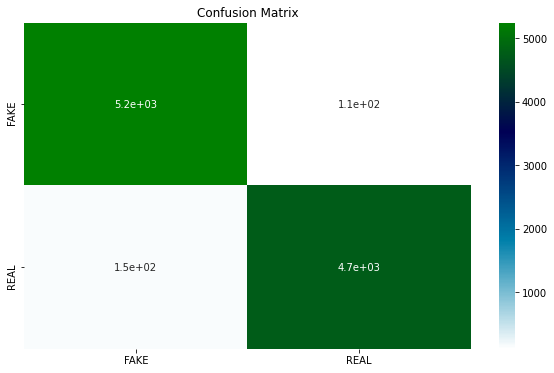

In [196]:
# Visualization of confusion-matrix with a heat-map
fig = plt.figure(figsize=(10,6))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

sns.heatmap(conf_mat, annot=True, cmap=plt.cm.ocean_r,
            xticklabels=['FAKE','REAL'], 
            yticklabels=['FAKE','REAL'])
plt.show()


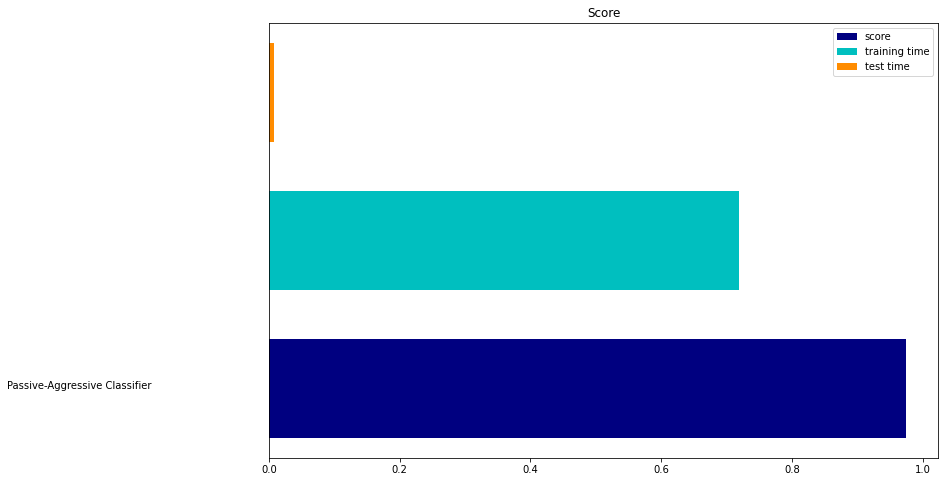

In [197]:
indices = np.arange(1)
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, train_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.text(-.4, indices[0], 'Passive-Aggressive Classifier')
plt.show()

<class 'list'> [[5245, 106], [148, 4748]]


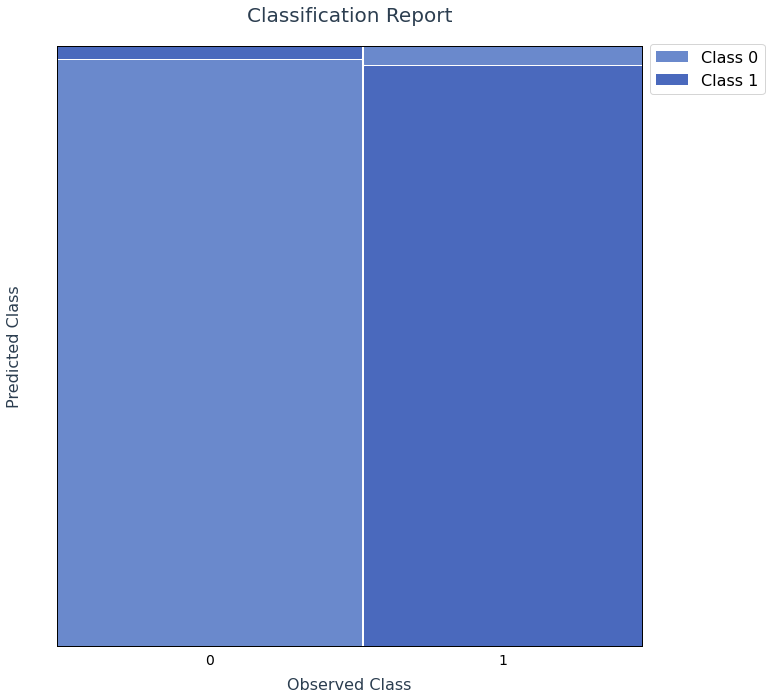

In [198]:
# Converting numpyarray to list
results = list()
for line in conf_mat:
  results.append([data for data in line])
print(type(results), results)

# visualize the results
nclass_classification_mosaic_plot(len(results), results)

# **Testing The Model with user input**

In [199]:
text_data = "In recent weeks, Microsoft has detected cyberattacks targeting people and organizations involved in the upcoming presidential election, including unsuccessful attacks on people associated with both the Trump and Biden campaigns, as detailed below. We have and will continue to defend our democracy against these attacks through notifications of such activity to impacted customers, security features in our products and services, and legal and technical disruptions. The activity we are announcing today makes clear that foreign activity groups have stepped up their efforts targeting the 2020 election as had been anticipated, and is consistent with what the U.S. government and others have reported. We also report here on attacks against other institutions and enterprises worldwide that reflect similar adversary activity." #@param {type:"raw"}
print(text_data)
x = [text_data,]

tfidf_test = tfidf_vectorizer.transform(x)

pred = model.predict(tfidf_test)

pred

print('This news is', pred[0])


In recent weeks, Microsoft has detected cyberattacks targeting people and organizations involved in the upcoming presidential election, including unsuccessful attacks on people associated with both the Trump and Biden campaigns, as detailed below. We have and will continue to defend our democracy against these attacks through notifications of such activity to impacted customers, security features in our products and services, and legal and technical disruptions. The activity we are announcing today makes clear that foreign activity groups have stepped up their efforts targeting the 2020 election as had been anticipated, and is consistent with what the U.S. government and others have reported. We also report here on attacks against other institutions and enterprises worldwide that reflect similar adversary activity.
This news is REAL
